# Rotational and divergent components

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Data analysis and viz libraries
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
# Local modules
import mypaths
from calc import spatial_mean, wind_rot_div
from commons import MODELS
from names import names
from plot_func import (
    KW_AUX_TTL,
    KW_AXGR,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    draw_scalar,
    draw_vector,
    figsave,
    linspace_pm1,
    make_map_figure,
)

In [4]:
plt.style.use("paper.mplstyle")


Bad key legend.labelcolor in file paper.mplstyle, line 10 ('legend.labelcolor : linecolor')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution


## Choose case

In [5]:
THAI_case = "Ben1"

## Constants

Define atmospheric and planetary constants. Note the planet's radius is in meters!

In [6]:
if THAI_case.endswith("1"):
    import const_ben1_hab1 as const
else:
    import const_ben2_hab2 as const

## Loading the data

Load the time-averaged data previously time-averaged and regridded.

In [7]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# Loop over THAI cases (this loop can swapped places with the loop below if needed)
for THAI_case in [THAI_case]:
    # for each of the THAI cases, create a nested directory for models
    datasets[THAI_case] = {}
    for model_key in MODELS.keys():
        model_names = names[model_key]
        ds = xr.open_dataset(mypaths.datadir / model_key / f"{THAI_case}_time_mean_{model_key}.nc")
        if model_key in ["ExoCAM", "LMDG", "ROCKE3D"]:
            # Regrid ExoCAM, LMD-G and ROCKE-3D data to be compatible with `windspharm`:
            # if latitudes are equally-spaced and even-numbered, they should not include poles.
            nlat = 50  # new number of latitudes: 50
            delta_lat = 180 / nlat
            new_lats = np.linspace(90 - 0.5 * delta_lat, -90 + 0.5 * delta_lat, nlat)
        else:
            new_lats = None
        ds_regr = {}
        for d in ds.data_vars:
            if (model_names.y in ds[d].dims) and (new_lats is not None):
                ds_regr[d] = (
                    ds[d]
                    .isel(**{model_names.y: slice(1, -1)})
                    .interp(
                        **{
                            model_names.y: new_lats,
                            "kwargs": {"fill_value": "extrapolate"},
                        },
                    )
                )
            else:
                ds_regr[d] = ds[d]
        datasets[THAI_case][model_key] = xr.Dataset(ds_regr)
        del ds

In [8]:
wind_cmpnts = {}
for model_key in MODELS.keys():
    ds = datasets[THAI_case][model_key]
    model_names = names[model_key]
    u = ds[model_names.u]
    v = ds[model_names.v]

    # Helmholtz decomposition
    wind_cmpnts[model_key] = wind_rot_div(u, v, truncation=None, const=const)

    # Vertical wind
    if model_key == "ExoCAM":
        # Approximately convert the pressure velocity (Pa/s) to the vertical wind velocity (m/s)
        rho = ds[model_names.pres] / (const.rgas * ds[model_names.temp])
        wind_cmpnts[model_key]["w"] = ds[model_names.w] * (-1 / (const.gplanet * rho))
    elif model_key in ["ROCKE3D", "LMDG"]:
        wind_cmpnts[model_key]["w"] = -1 * ds[model_names.w]
    else:
        wind_cmpnts[model_key]["w"] = ds[model_names.w]

## Diagnostics and plots

In [9]:
# P_LEVEL = 250
# height_constraints = {
#     "ExoCAM": {
#         "Ben1": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Ben2": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Hab1": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Hab2": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#     },
#     "LMDG": {
#         "Ben1": dict({names.lmdg.z: 7}, method="nearest"),
#         "Ben2": dict({names.lmdg.z: 7}, method="nearest"),
#         "Hab1": dict({names.lmdg.z: 7}, method="nearest"),
#         "Hab2": dict({names.lmdg.z: 7}, method="nearest"),
#     },
#     "ROCKE3D": {
#         "Ben1": dict({names.rocke3d.lev: 19}),
#         "Ben2": dict({names.rocke3d.lev: 20}),
#         "Hab1": dict({names.rocke3d.lev: 19}),
#         "Hab2": dict({names.rocke3d.lev: 20}),
#     },
#     "UM": {
#         "Ben1": dict({names.um.z: 11_500}, method="nearest"),
#         "Ben2": dict({names.um.z: 7_000}, method="nearest"),
#         "Hab1": dict({names.um.z: 11_000}, method="nearest"),
#         "Hab2": dict({names.um.z: 7_000}, method="nearest"),
#     },
# }

P_LEVEL = 300
height_constraints = {
    "ExoCAM": {
        "Ben1": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
        "Ben2": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
        "Hab1": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
        "Hab2": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
    },
    "LMDG": {
        "Ben1": dict({names.lmdg.z: 6}, method="nearest"),
        "Ben2": dict({names.lmdg.z: 6}, method="nearest"),
        "Hab1": dict({names.lmdg.z: 6}, method="nearest"),
        "Hab2": dict({names.lmdg.z: 6}, method="nearest"),
    },
    "ROCKE3D": {
        "Ben1": dict({names.rocke3d.lev: 18}),
        "Ben2": dict({names.rocke3d.lev: 18}),
        "Hab1": dict({names.rocke3d.lev: 19}),
        "Hab2": dict({names.rocke3d.lev: 20}),
    },
    "UM": {
        "Ben1": dict({names.um.z: 9_500}, method="nearest"),
        "Ben2": dict({names.um.z: 6_500}, method="nearest"),
        "Hab1": dict({names.um.z: 11_000}, method="nearest"),
        "Hab2": dict({names.um.z: 7_000}, method="nearest"),
    },
}

# P_LEVEL = 100
# height_constraints = {
#     "ExoCAM": {
#         "Ben1": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Ben2": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Hab1": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Hab2": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#     },
#     "LMDG": {
#         "Ben1": dict({names.lmdg.z: 7}, method="nearest"),
#         "Ben2": dict({names.lmdg.z: 7}, method="nearest"),
#         "Hab1": dict({names.lmdg.z: 11.39}, method="nearest"),
#         "Hab2": dict({names.lmdg.z: 11.39}, method="nearest"),
#     },
#     "ROCKE3D": {
#         "Ben1": dict({names.rocke3d.lev: 19}),
#         "Ben2": dict({names.rocke3d.lev: 20}),
#         "Hab1": dict({names.rocke3d.lev: 26}),
#         "Hab2": dict({names.rocke3d.lev: 26}),
#     },
#     "UM": {
#         "Ben1": dict({names.um.z: 11_500}, method="nearest"),
#         "Ben2": dict({names.um.z: 7_000}, method="nearest"),
#         "Hab1": dict({names.um.z: 16875.31}, method="nearest"),
#         "Hab2": dict({names.um.z: 12499.999}, method="nearest"),
#     },
# }

# P_LEVEL = 400
# height_constraints = {
#     "ExoCAM": {
#         "Ben1": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Ben2": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Hab1": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Hab2": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#     },
#     "LMDG": {
#         "Ben1": dict({names.lmdg.z: 5}, method="nearest"),
#         "Ben2": dict({names.lmdg.z: 5}, method="nearest"),
#         "Hab1": dict({names.lmdg.z: 4.196}, method="nearest"),
#         "Hab2": dict({names.lmdg.z: 5}, method="nearest"),
#     },
#     "ROCKE3D": {
#         "Ben1": dict({names.rocke3d.lev: 15}),
#         "Ben2": dict({names.rocke3d.lev: 15}),
#         "Hab1": dict({names.rocke3d.lev: 15}),
#         "Hab2": dict({names.rocke3d.lev: 15}),
#     },
#     "UM": {
#         "Ben1": dict({names.um.z: 5120}, method="nearest"),
#         "Ben2": dict({names.um.z: 5120}, method="nearest"),
#         "Hab1": dict({names.um.z: 7220}, method="nearest"),
#         "Hab2": dict({names.um.z: 5120}, method="nearest"),
#     },
# }
# P_LEVEL = 950
# height_constraints = {
#     "ExoCAM": {
#         "Ben1": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Ben2": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Hab1": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#         "Hab2": dict({names.exocam.lev: P_LEVEL}, method="nearest"),
#     },
#     "LMDG": {
#         "Ben1": dict({names.lmdg.z: 0.3}, method="nearest"),
#         "Ben2": dict({names.lmdg.z: 0.3}, method="nearest"),
#         "Hab1": dict({names.lmdg.z: 0.3}, method="nearest"),
#         "Hab2": dict({names.lmdg.z: 0.3}, method="nearest"),
#     },
#     "ROCKE3D": {
#         "Ben1": dict({names.rocke3d.lev: 3}),
#         "Ben2": dict({names.rocke3d.lev: 3}),
#         "Hab1": dict({names.rocke3d.lev: 3}),
#         "Hab2": dict({names.rocke3d.lev: 3}),
#     },
#     "UM": {
#         "Ben1": dict({names.um.z: 11_500}, method="nearest"),
#         "Ben2": dict({names.um.z: 7_000}, method="nearest"),
#         "Hab1": dict({names.um.z: 11_000}, method="nearest"),
#         "Hab2": dict({names.um.z: 320}, method="nearest"),
#     },
# }

In [10]:
WIND_CMPNT_META = {
    "total": {"title": "Total", "qk_ref_wspd": 50, "kw_plt": dict(color="#222222")},
    "rot_zm": {
        "title": "Zonal mean rotational",
        "qk_ref_wspd": 50,
        "kw_plt": dict(color="C1"),
    },
    "rot_eddy": {
        "title": "Eddy rotational",
        "qk_ref_wspd": 25,
        "kw_plt": dict(color="C2"),
    },
    "div": {"title": "Divergent", "qk_ref_wspd": 10, "kw_plt": dict(color="C0")},
}
KW_QUIVER = dict(
    scale_units="inches",
    scale=100,
    cmap="magma_r",
    # facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.15,
    width=0.004,
    headaxislength=4,
)
KW_QUIVERKEY = dict(
    labelpos="N",
    labelsep=0.05,
    coordinates="axes",
    color="#444444",
    fontproperties=dict(size="large"),
)
KW_W_CNTRF = dict(cmap="RdBu_r", levels=linspace_pm1(10) * 0.1, extend="both")
KW_YLABEL = dict(
    va="bottom",
    ha="center",
    rotation="vertical",
    rotation_mode="anchor",
)
skips = {
    "ExoCAM": (4, 3),
    "LMDG": (4, 3),
    "ROCKE3D": (4, 3),
    "UM": (8, 6),
}

LMDG 30370.788272320566
ROCKE3D 303.8623499870745
UM 30698.556373631356


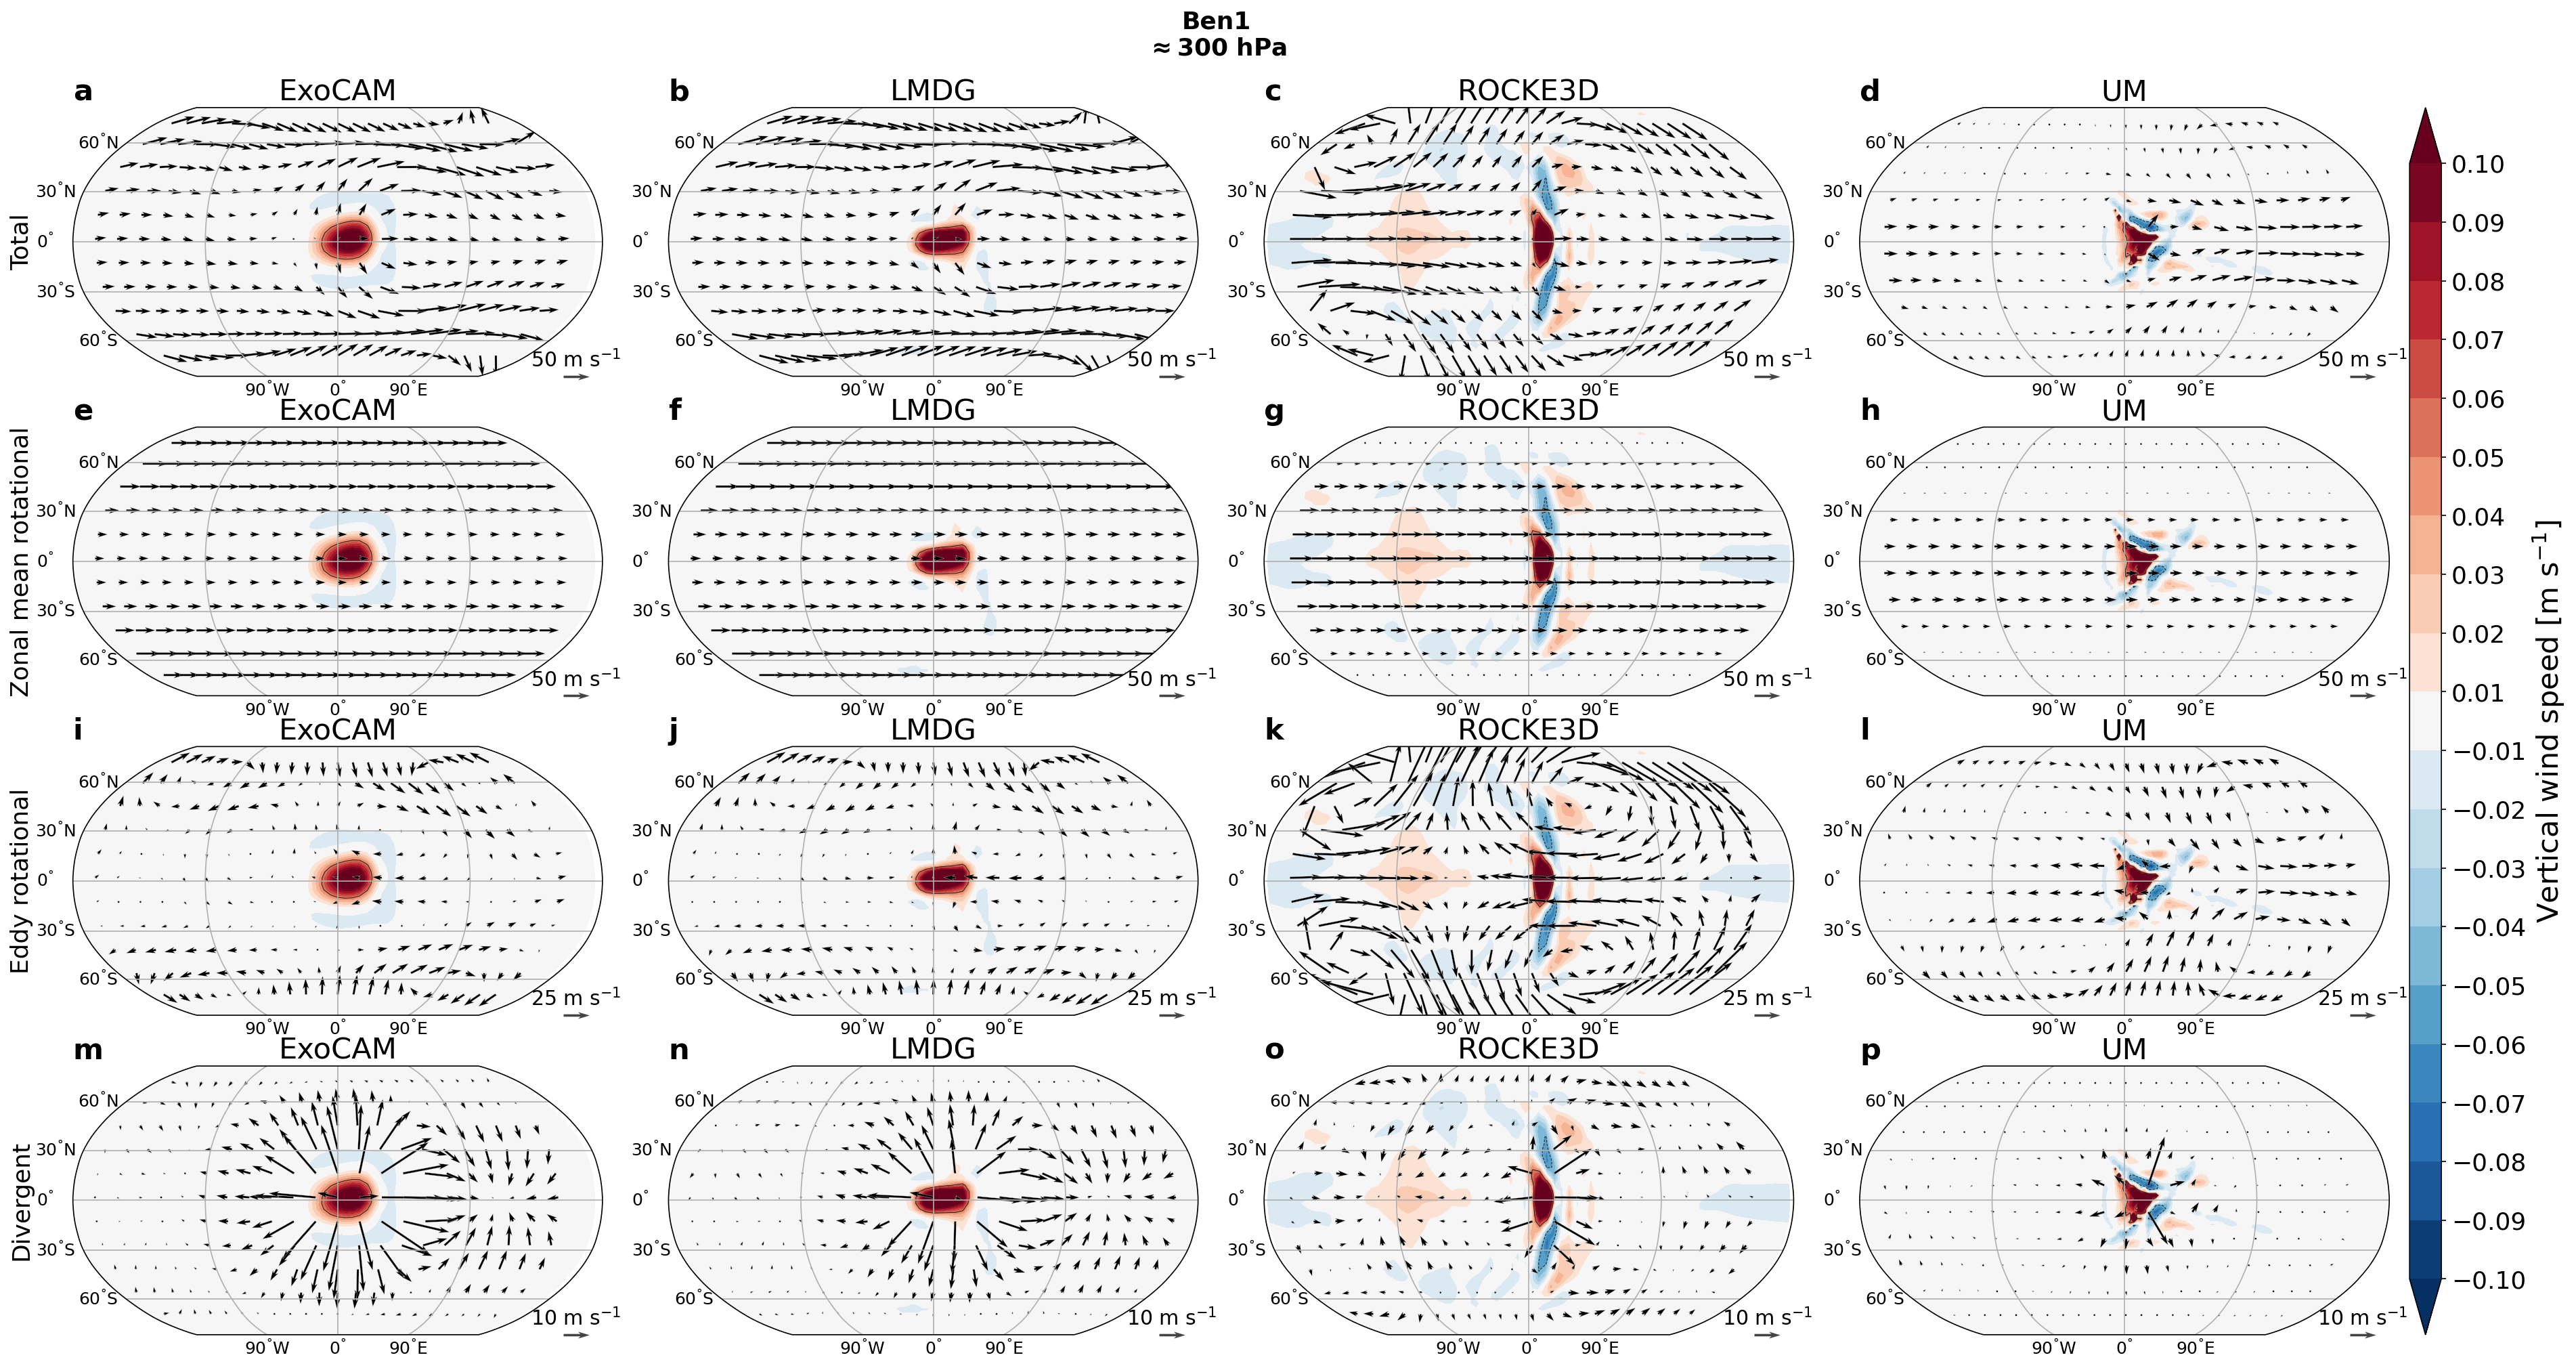

In [11]:
ncols = 4
nrows = 4
fig, axgr = make_map_figure(ncols, nrows, **KW_AXGR)
# cbar_axes_col = np.array(axgr.cbar_axes).reshape((3, 2)).T
cax = axgr.cbar_axes[0]
fig.suptitle(f"{THAI_case}\n" + fr"$\approx${P_LEVEL} hPa", fontweight="bold", y=0.94, fontsize="x-large")

for i, (model_key, axcol) in enumerate(zip(MODELS.keys(), axgr.axes_column)):
    model_names = getattr(names, model_key.lower())
    lev_sel = height_constraints[model_key][THAI_case]
    if model_key != "ExoCAM":
        print(
            model_key,
            float(spatial_mean(datasets[THAI_case][model_key][model_names.pres].sel(**lev_sel))),
        )
    for ax, (wind_key, wind_meta) in zip(axcol, WIND_CMPNT_META.items()):
        ax.set_title(model_key, **KW_MAIN_TTL)
        # ax.set_title(, **KW_AUX_TTL)
        if i == 0:
            ax.text(
                -0.075,
                0.5,
                wind_meta["title"],
                fontsize="x-large",
                **KW_YLABEL,
                transform=ax.transAxes,
            )
        w_cntrf = draw_scalar(
            wind_cmpnts[model_key]["w"].sel(**lev_sel),
            ax,
            method="contourf",
            # cax=cax,
            # tex_units="$m$ $s^{-1}$",
            # cbar_ticks=KW_W_CNTRF["levels"],
            use_cyclic=False,
            model_names=model_names,
            **KW_W_CNTRF,
        )
        draw_scalar(
            wind_cmpnts[model_key]["w"].sel(**lev_sel),
            ax,
            method="contour",
            use_cyclic=False,
            model_names=model_names,
            colors="#222",
            linewidths=0.5,
            levels=[-0.05, 0.05],
        )
        u, v = (
            wind_cmpnts[model_key][f"u_{wind_key}"].sel(**lev_sel),
            wind_cmpnts[model_key][f"v_{wind_key}"].sel(**lev_sel),
        )
        _wspd = (u ** 2 + v) ** 0.5
        QK_REF_WSPD = wind_meta["qk_ref_wspd"]
        _kw_quiv = {
            **KW_QUIVER,
            "scale": QK_REF_WSPD * 4,
            "norm": plt.Normalize(0, QK_REF_WSPD),
        }
        draw_vector(
            u,
            v,
            ax,
            # cax=cax,
            tex_units="$m$ $s^{-1}$",
            # cbar_ticks=None,
            # mag=(_wspd,),
            xstride=skips[model_key][0],
            ystride=skips[model_key][1],
            qk_ref_wspd=QK_REF_WSPD,
            kw_quiver=_kw_quiv,
            kw_quiverkey=KW_QUIVERKEY,
            model_names=model_names,
            quiverkey_xy=(0.95, 0.0),
        )
        ax.set_global()

cb = fig.colorbar(w_cntrf, cax=cax, aspect=80)
cb.ax.set_ylabel("Vertical wind speed [$m$ $s^{-1}$]", fontsize="xx-large")
cb.set_ticks(KW_W_CNTRF["levels"])
cb.ax.tick_params(labelsize="x-large")

In [12]:
figsave(
    fig,
    mypaths.plotdir / f"{THAI_case}__rot_div_vert_wind_map__{int(P_LEVEL)}hpa",
)

Saved to ../plots/Ben1__rot_div_vert_wind_map__300hpa.png


In [ ]:
# model_key = "UM"
# model_names = getattr(names, model_key.lower())
# ds = datasets[THAI_case][model_key]
# lon2d, lat2d = np.meshgrid(ds[model_names.x], ds[model_names.y])
# lev_sel = dict({model_names.z: 11.5e3}, method="nearest")

In [ ]:
# %%time
# ncols = 4
# nrows = 4
# fig, axgr = make_map_figure(ncols, nrows, **KW_AXGR)
# # cbar_axes_col = np.array(axgr.cbar_axes).reshape((3, 2)).T
# cax = axgr.cbar_axes[0]

# for ax, (wind_key, wind_meta) in zip(axgr.axes_column, WIND_CMPNT_META.items()):
#     ax.set_title(wind_meta["title"], **KW_MAIN_TTL)
#     ax.set_title(f"({next(iletters)})", **KW_SBPLT_LABEL)
#     ax.set_ylim(-90, 90)
#     ax.set_yticks(YLOCS)
#     ax.set_yticklabels([fmt_lonlat(i, "lat", True) for i in YLOCS])
#     ax.set_xlim(-180, 180)
#     ax.set_xticks(XLOCS)
#     ax.set_xticklabels([fmt_lonlat(i, "lon", True) for i in XLOCS])
#     if ax.is_first_col():
#         ax.set_ylabel("Latitude [$\degree$]")
#     if ax.is_last_row():
#         ax.set_xlabel("Longitude [$\degree$]")
#     ax.contourf(
#         lons.points,
#         lats.points,
#         w_plev.extract(lev_constr).data,
#         cmap=cm.vik,
#         levels=clev101(11) * 5e-2,
#         extend="both",
#     )
#     u, v = (
#         wind_cmpnts[model_key][f"u_{wind_key}"].sel(**lev_sel),
#         wind_cmpnts[model_key][f"v_{wind_key}"].sel(**lev_sel),
#     )
#     QK_REF_WSPD = wind_meta["qk_ref_wspd"]
#     _kw_quiv = {**KW_QUIVER, **{"scale": QK_REF_WSPD * 4}}
#     quiv = ax.quiver(
#         lon2d[SKIP], lat2d[SKIP],
#         u[SKIP],
#         v[SKIP],
#         (u[SKIP] ** 2 + v[SKIP] ** 2) ** 0.5,
#         norm=plt.Normalize(0, wind_meta["qk_ref_wspd"]),
#         **_kw_quiv,
#     )
#     qk = ax.quiverkey(
#         quiv,
#         *(0.125, 0.9),
#         QK_REF_WSPD,
#         fr"${QK_REF_WSPD}$" + r" $m$ $s^{-1}$",
#         **KW_QUIVERKEY,
#     )
#     fig.colorbar(quiv, ax=ax)
# fig.suptitle(
#     f'{THAI_case}\n{int(100500):d} hPa',
#     y=0.95,
# )